# Stage LIESSE – TP 2 – Réseaux de neurones 

Le but de ce notebook est de présenter les réseaux de neurones multi-couches à propagation avant, aussi appelés perceptrons multi-couches, ou _MLP_ pour _multi-layer perceptrons_.

## Chargement des librairies

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [3]:
import pandas as pd

In [4]:
import sklearn

## 1. Réseaux de neurones pour la régression 

Reprenons le Problème 1 défini dans le notebook `0-Donnees.ipynb`. Peut-on améliorer la performance de la régression linéaire en utilisant un modèle non linéaire ?

### Chargement des données

In [5]:
penguins = pd.read_csv("data/penguins.csv")

In [6]:
X = penguins[["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]].to_numpy()
y_regress = penguins["body_mass_g"]

### Séparation des données en jeu d'entraînement et jeu de test

In [7]:
from sklearn import model_selection

In [8]:
(X_train, X_test, y_train, y_test) = model_selection.train_test_split(X, y_regress, test_size=0.3, random_state=25)

### Formalisme

Nous disposons toujours d'un jeu d'entraînement de $n$ observations en $p$ dimensions, représentés par une matrice $X \in \mathbb{R}^{nxp}$ (ici, $p=3$), et d'un vecteur d'étiquettes $\boldsymbol{y} \in \mathbb{R}^{n}$. 

Un réseau de neurones multi-couches permet d'apprendre un modèle différent de celui de la régression linéaire. Là où nous avions précédemment un modèle de la forme 
$f: \boldsymbol{x} \in \mathbb{R}^p \mapsto \beta_0 + \boldsymbol{\beta}^\top \boldsymbol{x},$
avec $\beta_0 \in \mathbb{R}$ et $\boldsymbol\beta \in \mathbb{R}^p$,
la forme du modèle est maintenant donnée par l'architecture du réseau.

Si nous utilisons une __couche intermédiaire__ contenant $m$ neurones, le modèle devient 
$f: \boldsymbol{x} \in \mathbb{R}^p \mapsto \beta_0^1 + \sum_{k=1}^m \beta_k^1 a \left( \beta^0_{0k} + \boldsymbol{\beta}_k^{0\top} \boldsymbol{x} \right),$

avec :
 * $a$ une __fonction d'activation__ non-linéaire, par exemple logistique ou ReLU ;
 * $\beta_0^1 \in \mathbb{R}$ le biais de la couche intermédiaire et $\boldsymbol\beta^1 \in \mathbb{R}^m$ les coefficients de la couche intermédiaire vers le neurone de sortie ;
 * pour $k=1, \dots, m$, $\beta_0^{0k} \in \mathbb{R}$ le biais du $k$-ème neurone de la couche intermédiaire et $\boldsymbol\beta_k^0 \in \mathbb{R}^p$ les coefficients de la couche d'entrée vers le  $k$-ème neurone de la couche intermédiaire. 

Il s'agit par contre toujours de __minimiser le risque empirique__, qui est toujours calculé avec l'__erreur quadratique__ $(y, f(\boldsymbol{x})) \mapsto \left(y - f(\boldsymbol{x}) \right)^2 $ comme fonction de perte. 

Attention, ce problème d'optimisation n'est en général pas convexe. On risque d'obtenir un minimum local.

### Entraînement d'un réseau de neurones avec scikit-learn

Nous allons utiliser un réseau de neurones avec une seule couche intermédiaire contenant $m=10$ neurones.

Là où il s'agissait, pour une régression linéaire, d'apprendre $p+1=4$ paramètres, nous avons maintenant $m \times (p+1) + (m+1) = 51$ paramètres à apprendre.

Les réseaux de neurones sont implémentés dans [le module `neural_network`](https://scikit-learn.org/dev/modules/classes.html?highlight=neural_network#module-sklearn.neural_network) de `scikit-learn`. Pour la régression, nous utilisons [la classe `MLPRegressor`](https://scikit-learn.org/dev/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor). 

In [9]:
from sklearn import neural_network

Nous suivons exactement les étapes habituelles :

1. Instancions un objet de la classe de modèle qui nous intéresse, ici `MLPRegressor`.

Comme le nombre d'observation est faible (seulement quelques centaines), nous utilisons le solveur LBFGS qui, selon la documentation, est plus approprié. Pour faciliter la convergence, nous augmentons aussi le nombre d'itérations en le fixant à 1000. Nous conservons par ailleurs les paramètres par défaut ; en particulier, nous utilisons une fonction d'activation ReLU.

ReLU signifie _Rectified Linear Unit_ et retourne simplement la partie postive du nombre qu'on lui passe.

In [10]:
mlpreg = neural_network.MLPRegressor(hidden_layer_sizes=10, solver='lbfgs', max_iter=1000, random_state=47)

2. Entraînons cet objet sur les données d'entraînement avec la méthode `fit` :

In [11]:
mlpreg.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=10, max_iter=1000, random_state=47,
             solver='lbfgs')

Il se peut ici que vous receviez un message d'erreur car le solveur ne converge pas. Vous pouvez relancer plusieurs fois l'appel à `fit` (la convergence dépendant de l'initialisation, qui est aléatoire). Si cela ne suffit pas, augmentez le nombre d'itérations en augmentant la valeur du paramètre `max_iter` ou relâchez la tolérance en augmentant la valeur du paramètre `tol`.

3. Enfin, prédisons les étiquettes des données du jeu de test en utilisant la méthode `predict` :

In [12]:
y_test_pred = mlpreg.predict(X_test)

### Performance du modèle

On peut maintenant s'intéresser à la qualité du modèle. Commençons par visualiser la corrélation entre les valeurs réelles et les valeurs prédites :

Text(0, 0.5, 'Poids prédit (g)')

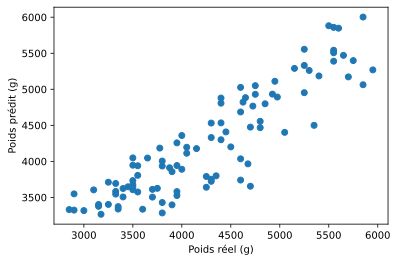

In [13]:
plt.scatter(y_test, y_test_pred)

plt.xlabel("Poids réel (g)")
plt.ylabel("Poids prédit (g)")

In [14]:
from sklearn import metrics

In [15]:
print("La RMSE de notre modèle est %.2f g" % (metrics.mean_squared_error(y_test, y_test_pred, squared=False)))

La RMSE de notre modèle est 362.75 g


In [16]:
print("Le coefficient de détermination de notre modèle est R2 = %.2f" % (metrics.r2_score(y_test, y_test_pred)))

Le coefficient de détermination de notre modèle est R2 = 0.80


### Difficulté de l'apprentissage avec un réseau de neurones

Utiliser ce réseau de neurones a légèrement amélioré la performance, par rapport à la régression linéaire. Cependant, cela dépend énormément des _hyperparamètres_ du modèle, c'est-à-dire du nombre de couches intermédiaires, du nombre de neurones par couches, du choix de la fonction d'activation, ainsi que de l'initialisation aléatoire. 

Vous pouvez le vérifier en modifiant ces choix :

In [17]:
mlpreg = neural_network.MLPRegressor(hidden_layer_sizes=20, solver='lbfgs', max_iter=1000, random_state=47)

In [18]:
mlpreg.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=20, max_iter=1000, random_state=47,
             solver='lbfgs')

In [19]:
y_test_pred = mlpreg.predict(X_test)

Text(3000, 5200, 'R2 = 0.72')

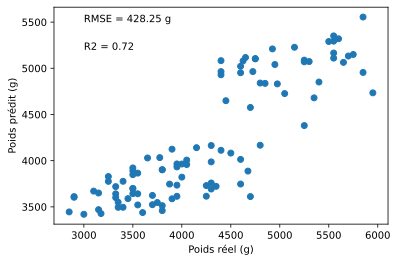

In [20]:
plt.scatter(y_test, y_test_pred)

plt.xlabel("Poids réel (g)")
plt.ylabel("Poids prédit (g)")

plt.text(3000, 5500, ("RMSE = %.2f g" % (metrics.mean_squared_error(y_test, y_test_pred, squared=False))))
plt.text(3000, 5200, ("R2 = %.2f" % (metrics.r2_score(y_test, y_test_pred))))

## 2. Réseau de neurones pour la classification

Reprenons le Problème 2 défini dans le notebook `0-Donnees.ipynb`. Peut-on améliorer la performance de la régression linéaire en utilisant un modèle non linéaire ?

### Chargement des données

In [21]:
y_classif = pd.Categorical(penguins["sex"]).astype('category').codes

### Séparation des données en jeu d'entraînement et jeu de test

In [22]:
(X_train, X_test, y_train, y_test) = model_selection.train_test_split(X, y_classif, test_size=0.3, random_state=25, 
                                                                      stratify=y_classif)

### Formalisme 

Le perceptron multi-couches pour la classification est au perceptron multi-couches pour la régression ce que la régression logistique est à la régression linéaire.

Nous disposons de $n$ observations en $p$ dimensions, représentés par une matrice $X \in \mathbb{R}^{nxp}$ (ici, $p=3$), et d'un vecteur d'étiquettes $\boldsymbol{y} \in \{0, 1\}^{n}$. 

Comme dans la régression logistique, il s'agit de modéliser la probabilité qu'une observation appartienne à la classe positive, autrement dit ait l'étiquette 1, par une transformation logistique d'une fonction $f$, cette fois non-linéaire, des variables. En notant $X$ un vecteur alétaoire réel $p$-dimensionnel qui modélise un manchot et $Y$ une variable aléatoire discrète à valeurs dans $\{0, 1\}$ qui modélise son étiquette, on modélise donc toujours
$\mathbb{P}(Y = 1|X = \boldsymbol{x})$ par $f(\boldsymbol{x}).$ 

La forme de $f$ est donnée par l'architecture du réseau de neurones.
Pour un réseau de neurones à une couche cachée et $m$ neurones, la forme de $f$ est la même que ci-dessus pour le MPL pour la régression.

Pour trouver les paramètres de $f$, on a de nouveau recours à la __minimiation du risque empirique__ ; le risque empirique est calculé avec la __perte logistique__ $(y, f(\boldsymbol{x})) \mapsto - y \log(f(\boldsymbol{x})- (1-y) \log(1-f(\boldsymbol{x}))$ comme fonction de perte. 

Comme dans le cas du perceptron multi-couches pour la régression, ce problème d'optimisation n'est en général pas convexe. On risque d'obtenir un minimum local.

### Entraînement d'un réseau de neurones avec scikit-learn

Pour la classification, nous utilisons [la classe `MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). 

1. Instancions un objet de la classe `MLPClassifier`.

Nous utilisons cette fois la fonction logistique comme fonction d'activation.

In [23]:
mlpclass = neural_network.MLPClassifier(hidden_layer_sizes=10, activation='logistic', solver='lbfgs', max_iter=1000, random_state=47)

2. Entraînons cet objet sur les données d'entraînement avec la méthode `fit` :

In [24]:
mlpclass.fit(X_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=10, max_iter=1000,
              random_state=47, solver='lbfgs')

Il se peut ici que vous receviez un message d'erreur car le solveur ne converge pas. Vous pouvez relancer plusieurs fois l'appel à `fit` (la convergence dépendant de l'initialisation, qui est aléatoire). Si cela ne suffit pas, augmentez le nombre d'itérations en augmentant la valeur du paramètre `max_iter` ou relâchez la tolérance en augmentant la valeur du paramètre `tol`.

3. Enfin, prédisons les étiquettes des données du jeu de test en utilisant la méthode `predict` :

In [25]:
y_test_pred = mlpclass.predict(X_test)

### Performance

Regardons la __matrice de confusion__ des prédictions :

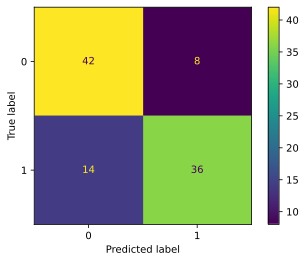

In [26]:
metrics.plot_confusion_matrix(mlpclass, X_test, y_test)

In [27]:
print("%d manchots mâles ont été incorrectement prédits femelle." % metrics.confusion_matrix(y_test, y_test_pred)[1, 0])
print("%d manchots femelles ont été incorrectement prédits mâles." % metrics.confusion_matrix(y_test, y_test_pred)[0, 1])

14 manchots mâles ont été incorrectement prédits femelle.
8 manchots femelles ont été incorrectement prédits mâles.


In [28]:
print("%.f%% des prédictions du modèle sur le jeu de test sont correctes." % (100*metrics.accuracy_score(y_test, y_test_pred)))

78% des prédictions du modèle sur le jeu de test sont correctes.
